In [40]:
import numpy as np
import random as rnd
import os
import re
from IPython.display import HTML, display
import matplotlib.pyplot as plt

In [41]:
languages = ['nodejs', 'java', 'graal', 'go', 'posix', 'arduino_due']
log_modes = ['monitor', 'monitor-bin']
modes = ['no', 'off', 'on']
fig_counter = 0
root='../../../src-gen/logs'

In [42]:
def allFiles(language, mode, log_mode):
    directory = os.fsencode(root + '/' + log_mode + '/' + mode)
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.split('-')[1] == language and filename.endswith('.log'): 
            yield root + '/' + log_mode + '/' + mode + '/' + filename
            
def loadMemory(filename, language):
    file = open(filename)
    while True:
        line = file.readline()      
        if not line:
            break
        if '>usedMem:' in line:
            mem = int(line[1:].strip().split(':')[1:][0])
            yield mem   
            
def loadTotalTime(filename):
    file = open(filename)
    while True:
        line = file.readline()      
        if not line:
            break                  
        if '>done in ' in line:
            time = int(line.split('>')[1][8:-4])
            return time

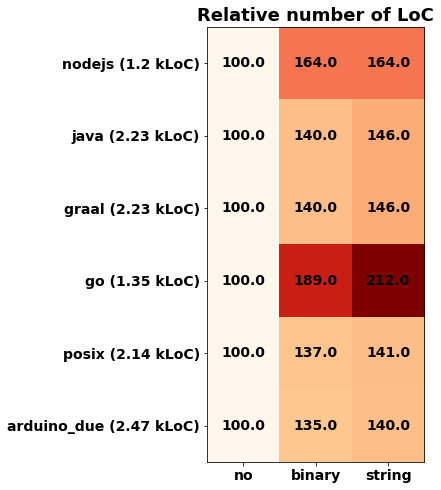

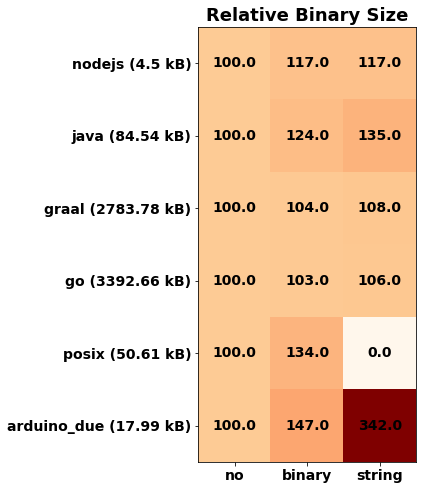

In [43]:
def allData(language, mode, log_mode):
    all_mem = []
    all_t = []
    for filename in allFiles(language, mode, log_mode):
        mem = np.array(list(loadMemory(filename, language))).astype(int).flatten()
        t = loadTotalTime(filename)
        all_mem.append(mem)
        all_t.append(t)
    return all_mem, all_t

def allStaticData(language):
    all_loc = []
    all_bin = []
    file = open(root + '/log.cloc')
    while True:
        line = file.readline()      
        if not line:
            break                  
        if language in line:            
            loc = 0
            bin = 0
            if ':loc:' in line:
                try:
                    loc = int(line.split(':loc:')[1])
                except:
                    loc = 0
                all_loc.append(loc)
            if ':bin:' in line:
                try:
                    bin = int(line.split(':bin:')[1])
                except:
                    bin = 0
                all_bin.append(bin)            
    return all_loc, all_bin

all_loc = []
all_bin = []
y_loc = []
y_bin = []
for language in languages:
    loc, bin = allStaticData(language)    
    all_loc.append(np.round(np.array(loc)/loc[0]*100,0))
    all_bin.append(np.round(np.array(bin)/bin[0]*100,0))
    y_loc.append(language + ' (' + str(np.round(loc[0]/1000,2)) + ' kLoC)')
    y_bin.append(language + ' (' + str(np.round(bin[0]/1000,2)) + ' kB)')
    
fig = plt.figure(fig_counter, figsize=(10,8))        
plt.imshow(all_loc, cmap='OrRd')
plt.xticks(range(0, 3), ('no', 'binary', 'string'), weight='heavy', fontsize=14)
plt.yticks(range(0, 6), y_loc, weight='heavy', fontsize=14)
for x_val in range(0, 3):
    for y_val in range(0, len(languages)):
        c = all_loc[y_val][x_val]
        plt.text(x_val, y_val, c, va='center', ha='center', weight='heavy', fontsize=14)
plt.title('Relative number of LoC', weight='heavy', fontsize=18)
plt.show()  
fig_counter = fig_counter + 1    


fig = plt.figure(fig_counter, figsize=(10,8))        
plt.imshow(all_bin, cmap='OrRd')
plt.xticks(range(0, 3), ('no', 'binary', 'string'), weight='heavy', fontsize=14)
plt.yticks(range(0, 6), y_bin, weight='heavy', fontsize=14)
for x_val in range(0, 3):
    for y_val in range(0, len(languages)):
        c = all_bin[y_val][x_val]
        plt.text(x_val, y_val, c, va='center', ha='center', weight='heavy', fontsize=14)
plt.title('Relative Binary Size', weight='heavy', fontsize=18)
plt.show()  
fig_counter = fig_counter + 1   

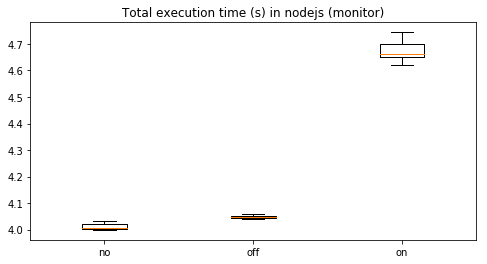

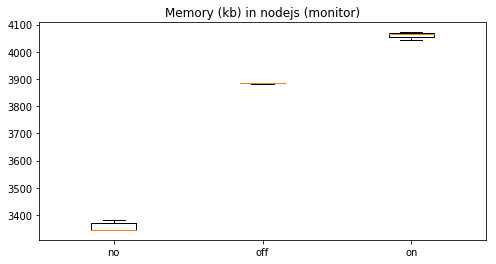

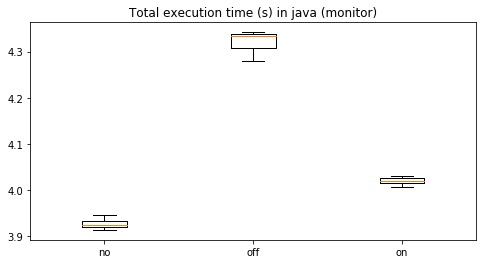

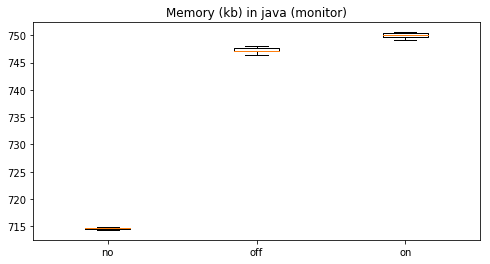

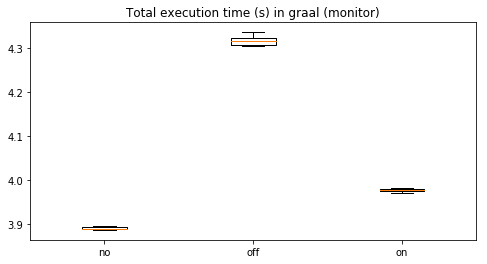

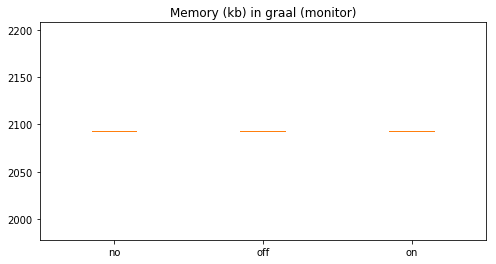

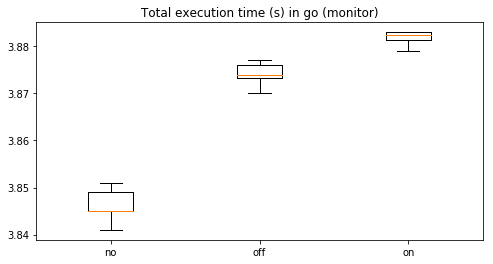

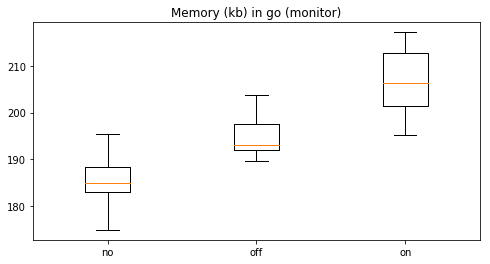

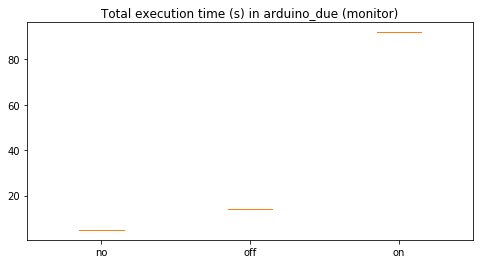

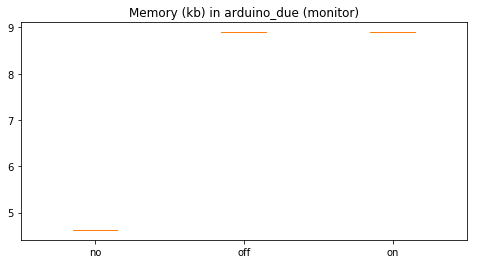

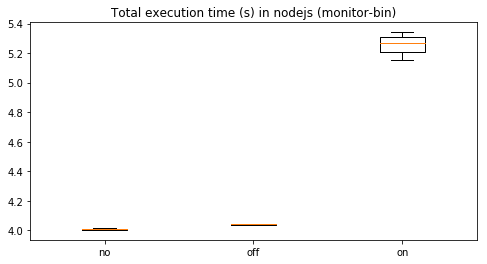

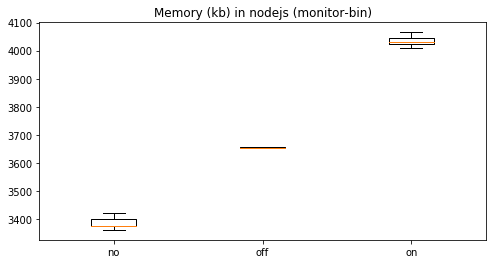

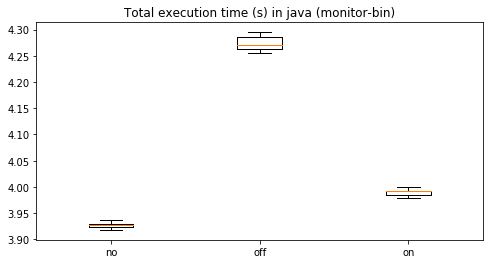

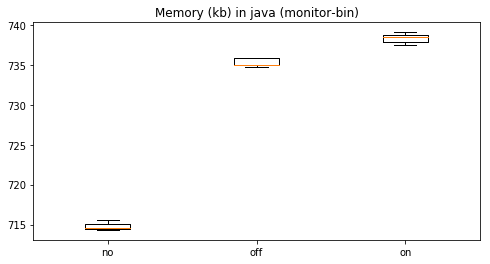

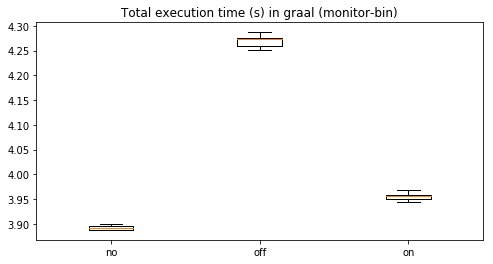

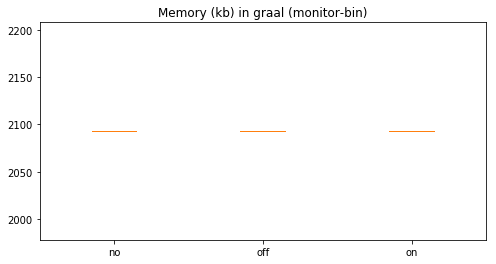

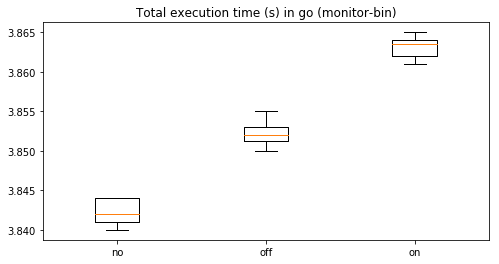

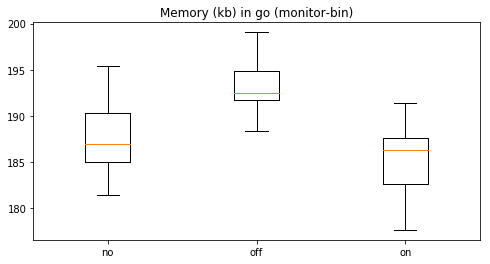

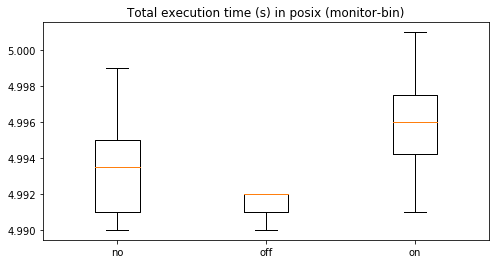

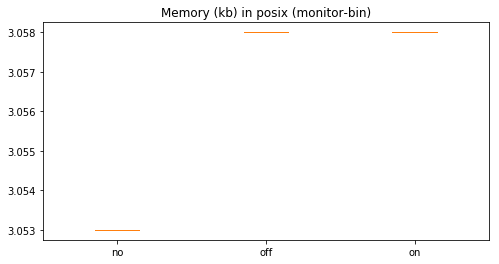

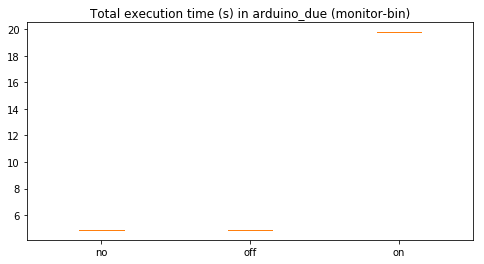

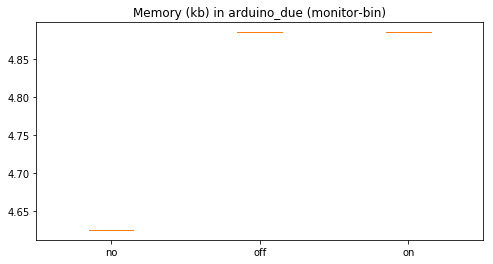

In [44]:
for log_mode in log_modes:
    global fig_counter
    for language in languages:            
        all_t = []
        all_mem = []
        hasError = False
        for mode in modes:
            try:
                mem, t = allData(language, mode, log_mode)
                all_t.append(np.array(t).flatten()/1000)
                all_mem.append(np.array(mem).flatten()/1000)
            except TypeError:
                hasError = True
                break
        
        if hasError:
            continue
            
        fig = plt.figure(fig_counter, figsize=(8,4))        
        plt.boxplot(all_t, 0, '')
        plt.xticks(range(1, 4), ('no', 'off', 'on'))
        plt.title('Total execution time (s) in ' + language + ' (' + log_mode + ')')
        plt.show()  
        fig_counter = fig_counter + 1
    
        fig = plt.figure(fig_counter, figsize=(8,4))        
        plt.boxplot(all_mem, 0, '')
        plt.xticks(range(1, 4), ('no', 'off', 'on'))
        plt.title('Memory (kb) in ' + language + ' (' + log_mode + ')')
        plt.show()  
        fig_counter = fig_counter + 1
    

Processing posix on monitor: Error!


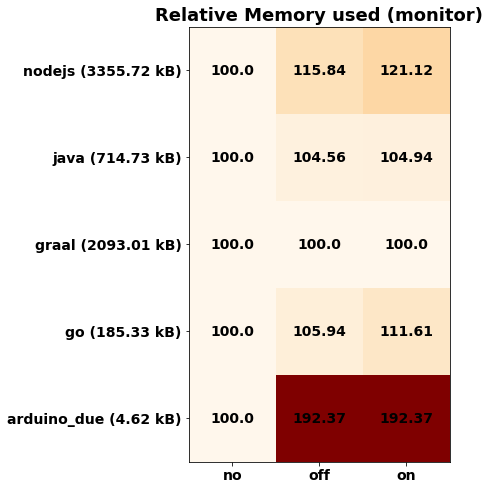

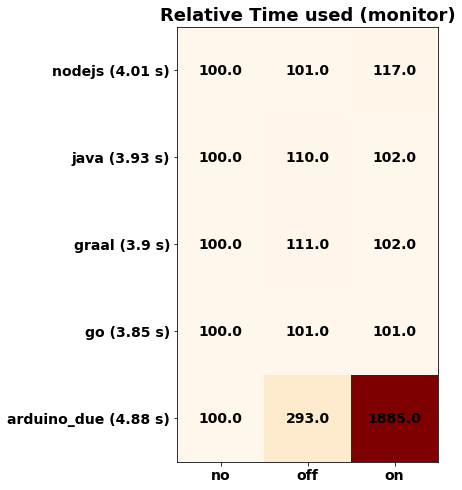

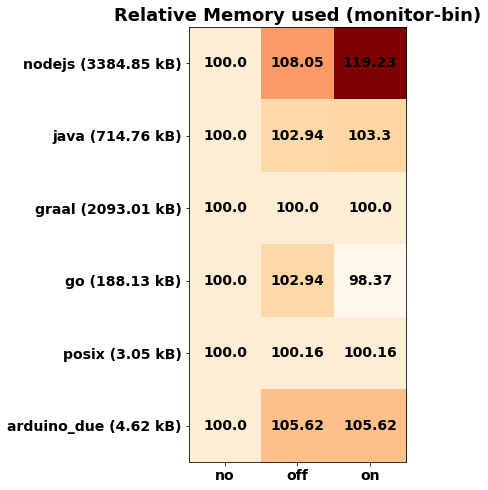

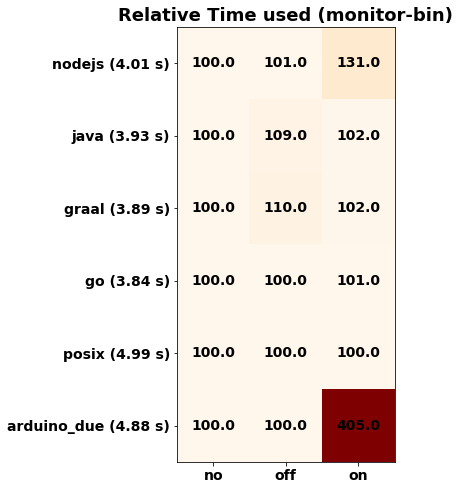

In [45]:
def mem_t_by_language(language, log_mode):
    all_t = []
    all_mem = []
    for mode in modes:
#         print('Processing ' + language + ' ' + mode + ' ' + log_mode + '...')
        mem, t = allData(language, mode, log_mode)
        all_t.append(np.mean(t))
        all_mem.append(np.mean(mem))
#     print(all_t)
#     print(all_mem)
    return all_mem, all_t

for log_mode in log_modes:
    global fig_counter
    all_t = []
    all_mem = []
    valid_lang_mem = []
    valid_lang_t = []
    for language in languages:                    
        hasError = False
        try:                
            mem, t = mem_t_by_language(language, log_mode)
            all_t.append(np.round(np.array(t)/t[0]*100,0))
            all_mem.append(np.round(np.array(mem)/mem[0]*100,2))
        except TypeError:
            print('Processing ' + language + ' ' + mode + ' ' + log_mode + ': Error!')
            hasError = True
        if not hasError:
            valid_lang_mem.append(language + ' (' + str(round(mem[0]/1000,2)) + ' kB)')
            valid_lang_t.append(language + ' (' + str(round(t[0]/1000,2)) + ' s)')
            
    
#     print(np.array(all_t).shape)
#     print(np.array(all_t))
#     print(np.array(all_mem).shape)
#     print(np.array(all_mem))
    
    fig = plt.figure(fig_counter, figsize=(10,8))        
    plt.imshow(all_mem, cmap='OrRd')
    plt.xticks(range(0, 3), ('no', 'off', 'on'), weight='heavy', fontsize=14)
    plt.yticks(range(0, len(valid_lang_mem)), valid_lang_mem, weight='heavy', fontsize=14)
    for x_val in range(0, 3):
        for y_val in range(0, len(valid_lang_mem)):
            c = all_mem[y_val][x_val]
            plt.text(x_val, y_val, c, va='center', ha='center', weight='heavy', fontsize=14)
    plt.title('Relative Memory used (' + log_mode + ')', weight='heavy', fontsize=18)
    plt.show()  
    fig_counter = fig_counter + 1
    
    fig = plt.figure(fig_counter, figsize=(10,8))        
    plt.imshow(all_t, cmap='OrRd')
    plt.xticks(range(0, 3), ('no', 'off', 'on'), weight='heavy', fontsize=14)
    plt.yticks(range(0, len(valid_lang_t)), valid_lang_t, weight='heavy', fontsize=14)
    for x_val in range(0, 3):
        for y_val in range(0, len(valid_lang_t)):
            c = all_t[y_val][x_val]
            plt.text(x_val, y_val, c, va='center', ha='center', weight='heavy', fontsize=14)
    plt.title('Relative Time used (' + log_mode + ')', weight='heavy', fontsize=18)
    plt.show()  
    fig_counter = fig_counter + 1
    